# 4. Exploratory Data Analaysis
---

### Introduction

The main objective of this Exploratory Data Analysis is to obtain information that can led the ML team to answers in order to predict a possible outcome of future cs-go matches. The hypotesis of the ML team is the following: ***It is possible to predict a cs-go match outcome by the information about the players.***

The dataset used for this EDA is player_match_data.csv, which is a combination from the originals match_players.csv and match_results.csv. and was done through SQL queries as part of the proyect requirements. The resultant dataset provides information of every match from 2012 to 2017 from a player's perspective. 

Before starting the analysis, there are two main issues that must be corrected in order to continue. 
1. **There is no target variable**. Each row provides information about the player's performance in a match but there is no information about the outcome of the player.
2. **The player is not directly connected to a team**. Each row has the player id and the team name. Moreover, it has also the teams ids and scores. However, it falied to connect the team name provided with any of the team ids, so with the given information it is impossible to know if the player has won or lost the match. 

In order to solve this problems and continue with the EDA analysis, the following variables will be created:

1. **player_team_id**. This will be a id-variable that will bring the team id using the team name. Since it was not possible to take the team_id from another source because the names have small changes, it was decided to create a custom formula that iterates in all the matches played by a team and takes the most repeated team id as the team's id (reading both team 1 id and team 2 id).

2. **winning team**. A categorical variable called 'winning_team' and consists in a number (0, 1 or 2). This variable will calculate the diference between team_1_score and team_2_score and will return the winner of the match.
    - 0 means draw,
    - 1 means that team 1 has won the match,
    - 2 means that team 2 has won the match.

    This variable will be analyized as a possible target variable. 

3. **winning_team_id**. This will be a id-variable that simply returns the winning team id. It uses the winning team outcome and returns the ID of one of both teams, or 0 if the match resulted in a draw. This variable will be only used to support the target variable.

4. **player has won**. A categorical target variable that provides 1 or 0 depending whether the player was part of the winning team or not. This will be calculated using the player_team_id and winning_team_id. If they are the same, it will return a 1. This means that both defeats and draws will be counted as 0. 

### 4.0. Importing libraries & dataset and creating variables

***Importing Libraries and dataset***

In [13]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset
total_data = pd.read_csv('..\data\interim\player_match_data.csv')

***Overview of the dataset***

In [14]:
total_data.head(3)

,adr,assists,deaths,fkdiff,hs,kdratio,kills,rating,match_id,player_id,...,team_2_score,team_name,data_unix,map,hour,day,week,month,year,weekday
0,163.2,3,10,1,10,90.0%,32,2.44,32227,5736,...,16,g3x,1467476700000,Train,13,2,26,7,2016,5
1,81.0,3,6,1,5,75.0%,17,1.55,32227,2532,...,16,g3x,1467476700000,Train,13,2,26,7,2016,5
2,77.6,3,10,1,11,75.0%,16,1.41,32227,7382,...,16,g3x,1467476700000,Train,13,2,26,7,2016,5


***Creating variables***

In [15]:
    # Variable 1: player_team_id 

# 'player_team_id' function
def find_most_common_team_number(group):
        all_team_ids = pd.concat([group['team_1_id'], group['team_2_id']])
        team_numbers = all_team_ids.dropna().astype(int)
        most_common_team_number = np.argmax(np.bincount(team_numbers))
        return most_common_team_number

# Applying function to dataset
total_data['player_team_id'] = total_data.groupby('team_name').apply(find_most_common_team_number).reindex(total_data['team_name']).values

# ----------------------------------------------------------------------------------------------------------------------------

    # Variable 2: winning_team

# 'winning_team' function
def get_winning_team(team_1_score, team_2_score):
        if team_1_score == team_2_score: return 0
        elif team_1_score > team_2_score: return 1
        else: return 2

# Aapplying function to dataset
total_data['winning_team'] = total_data.apply(lambda row: get_winning_team(row['team_1_score'], row['team_2_score']), axis=1)

# ----------------------------------------------------------------------------------------------------------------------------

    # Variable 3: winning_team_id 

# Creating column called 'winning_team_id' (doesn't need function)
total_data['winning_team_id'] = np.where(total_data['winning_team'] == 1, total_data['team_1_id'],
                                np.where(total_data['winning_team'] == 2, total_data['team_2_id'], 0))

# ----------------------------------------------------------------------------------------------------------------------------

    # Variable 4: player_has_won 

# Creating column called 'player_has_won' (doesn't need function)
total_data['player_has_won'] = np.where(total_data['winning_team_id'] == total_data['player_team_id'], 1, 0)

# ----------------------------------------------------------------------------------------------------------------------------

# Seleccting target variables

target_1 = 'winning_team'
target_2 = 'player_has_won'

# Show small overview of the dataset
total_data.head(3)


,adr,assists,deaths,fkdiff,hs,kdratio,kills,rating,match_id,player_id,...,hour,day,week,month,year,weekday,player_team_id,winning_team,winning_team_id,player_has_won
0,163.2,3,10,1,10,90.0%,32,2.44,32227,5736,...,13,2,26,7,2016,5,6621,2,6621,1
1,81.0,3,6,1,5,75.0%,17,1.55,32227,2532,...,13,2,26,7,2016,5,6621,2,6621,1
2,77.6,3,10,1,11,75.0%,16,1.41,32227,7382,...,13,2,26,7,2016,5,6621,2,6621,1


After the four variables were created, it is possible to begin with the EDA analysis

---

### 4.1. Data description

***Dataset general information***

In [16]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946025 entries, 0 to 946024
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   adr              946025 non-null  object 
 1   assists          946025 non-null  int64  
 2   deaths           946025 non-null  int64  
 3   fkdiff           946025 non-null  int64  
 4   hs               946025 non-null  int64  
 5   kdratio          946025 non-null  object 
 6   kills            946025 non-null  int64  
 7   rating           946025 non-null  float64
 8   match_id         946025 non-null  int64  
 9   player_id        946025 non-null  int64  
 10  team_1_id        946025 non-null  int64  
 11  team_1_score     946025 non-null  int64  
 12  team_2_id        946025 non-null  int64  
 13  team_2_score     946025 non-null  int64  
 14  team_name        946025 non-null  object 
 15  data_unix        946025 non-null  int64  
 16  map              946025 non-null  obje

    1. Dataset general information:

The dataset contains 946.025 rows and 27 columns (including the two possible target columns). It is possible to divide the columns in four different groups:

- **Group 1: Match statistics**, from columns 0 to 7. These includes all the statistics from the game, including one called 'rating', which was created by the owner of the dataset. 
- **Group 2: IDs and names** of team, match and players, from columns 8 to 14.
- **Group 3: Time data**, from 16 to 22. These includes all time features.
- **Group 4: New variables and target** from 23 to 26. 

#

    2. Data types:

It is possible to find three types of data in this dataset: Numerical variables (columns 0 to 7), factorized categorical variables (columns 17 to 22), categorical variables (column 16 - map), numerical ids and score (columns 8 to 14, 23 and 25) and the two target variables, which are categorical (0, 1). There is only a time series variable, column 15 - data_unix, that provide the exact time the match was played.

    3. Null values

According to the general information, there are no null-values in the dataset. However, It is possible to see that three variables- adr, kdratio, map - are listed as object type and may contain invalid values in it. 


Due to this, the next step will be converting all the datatypes and inspecting if there are null variables in it.



### 4.2. Null values

***Converting 'adr' and 'kdratio' to numeric columns***

In [17]:
# Convert'adr' and 'kdratio' to numeric columns
total_data['adr'] = pd.to_numeric(total_data['adr'], errors='coerce')

# Kdratio is a % number, so it will be divided by 100
total_data['kdratio'] = pd.to_numeric(total_data['kdratio'].str.rstrip('%'), errors='coerce') / 100.0

# print a list with the info of the previous variables
total_data[['adr','kdratio']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946025 entries, 0 to 946024
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   adr      815862 non-null  float64
 1   kdratio  815988 non-null  float64
dtypes: float64(2)
memory usage: 14.4 MB


After the replacement and data type conversion its possible to see the following: 
- Column 'adr' has 130.163 null values, a 13.758% of the total entries.
- Column 'kdratio' has 130.037 null values, a 13.745% of the total entries.

***Analyze 'map' column***

In [18]:
total_data['map'].unique()

array(['Train', 'Dust2', 'Dust2_se', 'Cache', 'Mirage', 'Nuke', 'Inferno',
       'Cobblestone', 'Vertigo', 'Overpass', 'Nuke_se', 'Inferno_se',
       'Mirage_ce', 'Train_se', 'Season', 'Mill_ce', 'Tuscan', 'Ancient',
       'Dust_se', 'Train_ve'], dtype=object)

All the values in 'map' seems to be correct.

***Null-values replacement***

Since the variables 'adr' and 'kdratio' are numeric and both count with a normal distribution, the replacement of the null entries will follow this criteria:
1. Player's 'adr' or 'kdratio' will be filled with the player's mean of them.
2. If there is no information from the player to fill the nan, the row will be deleted.


In [19]:
# Group by 'player_id' and fill NaN values in each player's 'adr' column with the mean of non-null values for that player
total_data['adr'] = total_data.groupby('player_id')['adr'].transform(lambda x: x.fillna(x[x.notna()].mean()))
total_data['kdratio'] = total_data.groupby('player_id')['kdratio'].transform(lambda x: x.fillna(x[x.notna()].mean()))

# print a list with the info of the previous variables
total_data[['adr','kdratio']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946025 entries, 0 to 946024
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   adr      930980 non-null  float64
 1   kdratio  931002 non-null  float64
dtypes: float64(2)
memory usage: 14.4 MB


After the replacement, 'adr' and 'kdratio' still have null values (15.045 and 15.023 respectively).
The rest of rows with null values (1.59% of the dataset) will be deleted.

In [20]:
# Saving a copy of the rows with null values
null_rows = total_data.loc[total_data.isnull().any(axis=1)]

# Deleting rows with null values
total_data = total_data.dropna()

# print a list with the info of the previous variables
total_data[['adr','kdratio']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 930980 entries, 0 to 946024
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   adr      930980 non-null  float64
 1   kdratio  930980 non-null  float64
dtypes: float64(2)
memory usage: 21.3 MB


Without the null-values, the total length of the dataset is 930.980 rows.

### 4.3. Multivariable analysis

***Numerical - numerical analysis***

The following analysis will be held by parts. First, the *statistcs* group will be analyzed and then the *time* group. Both target will be taken into account.

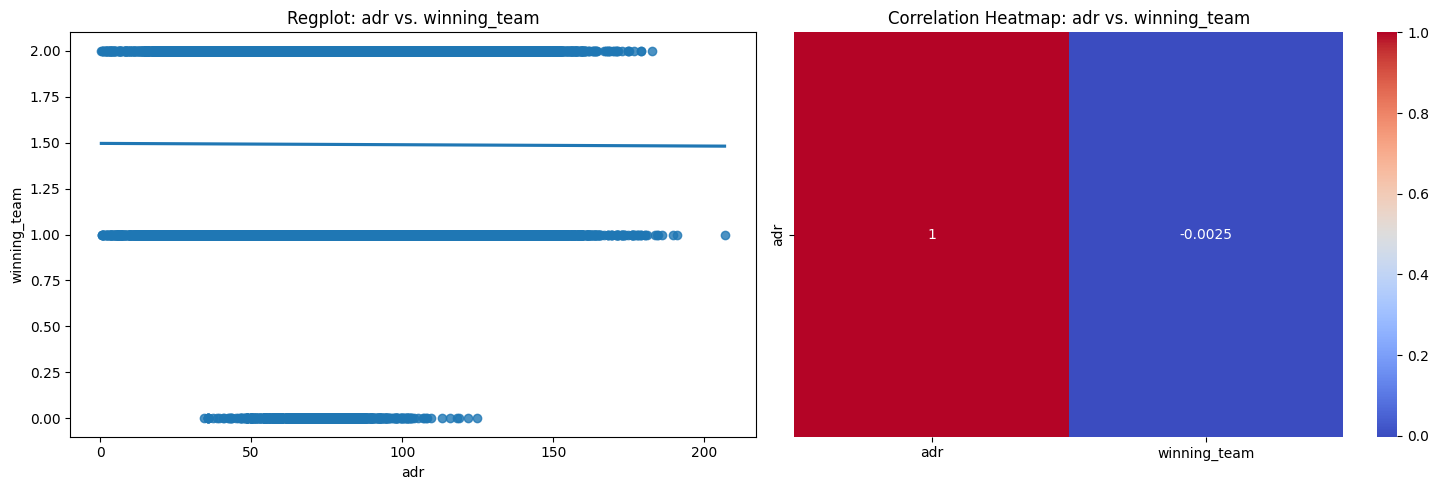

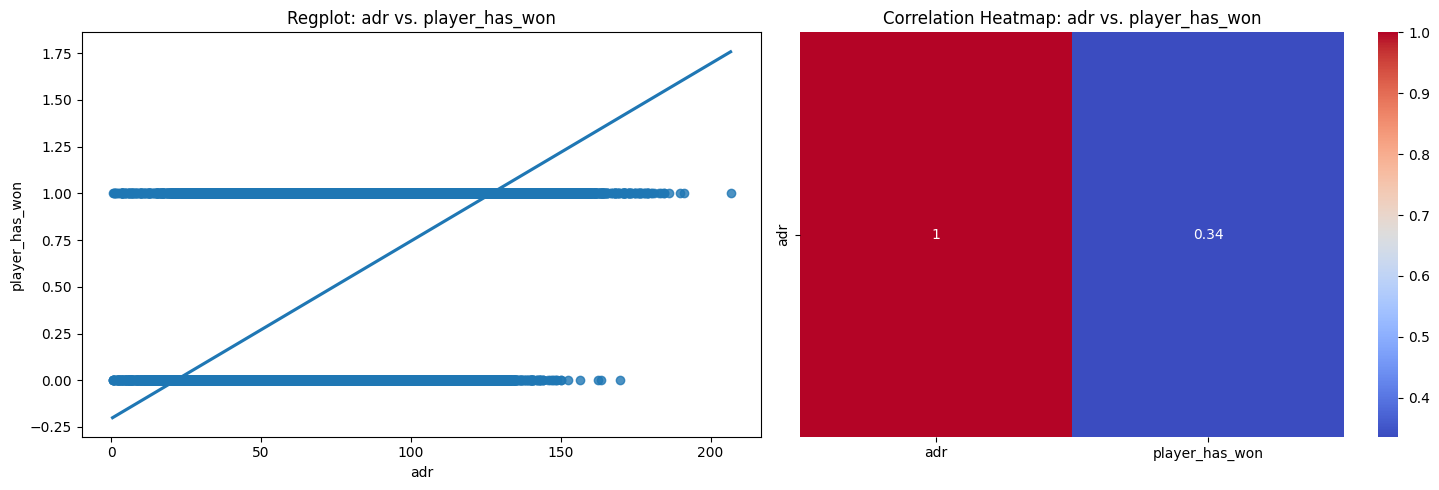

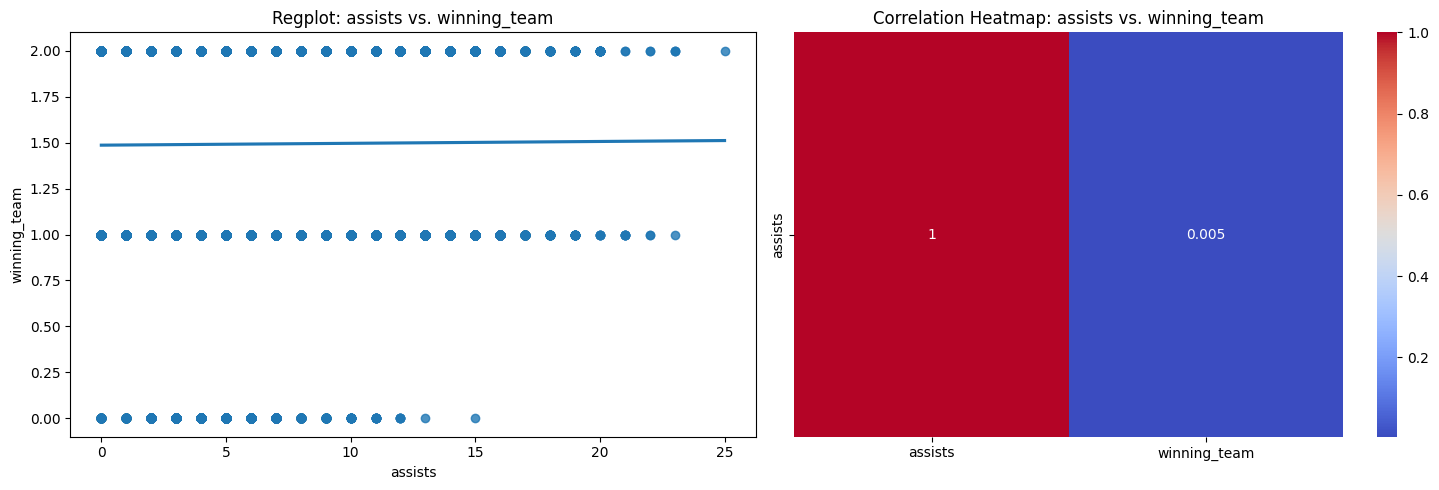

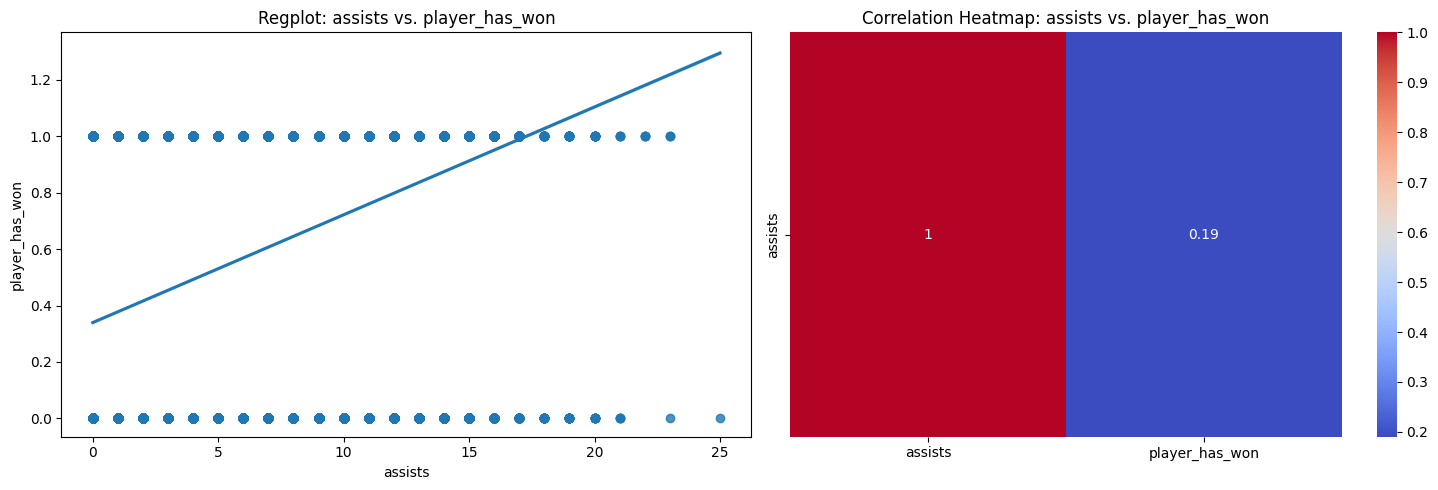

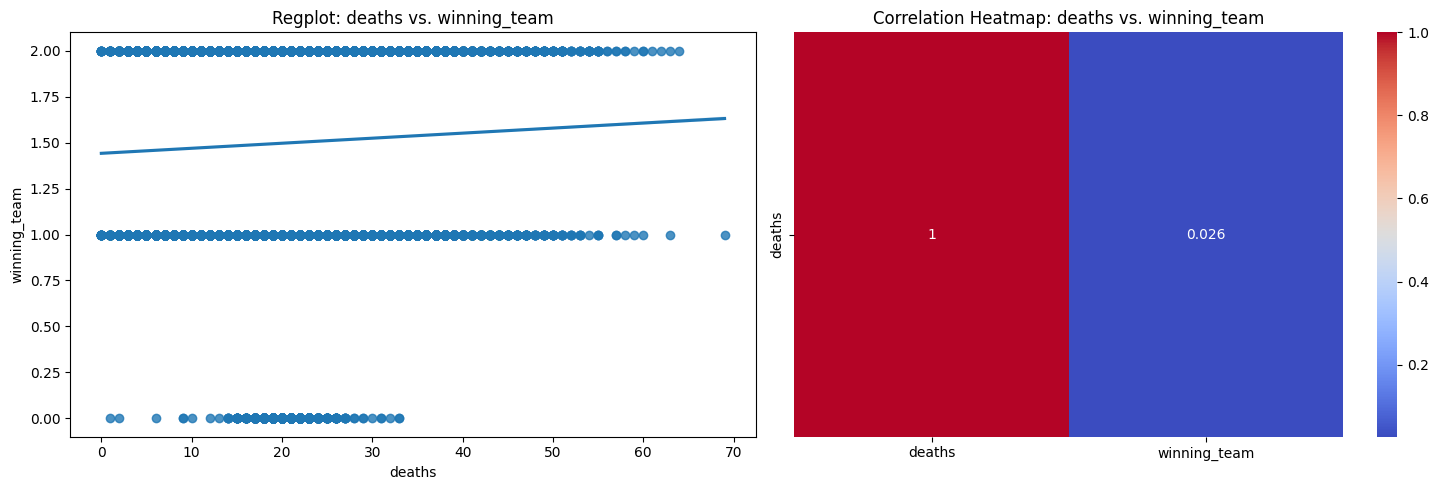

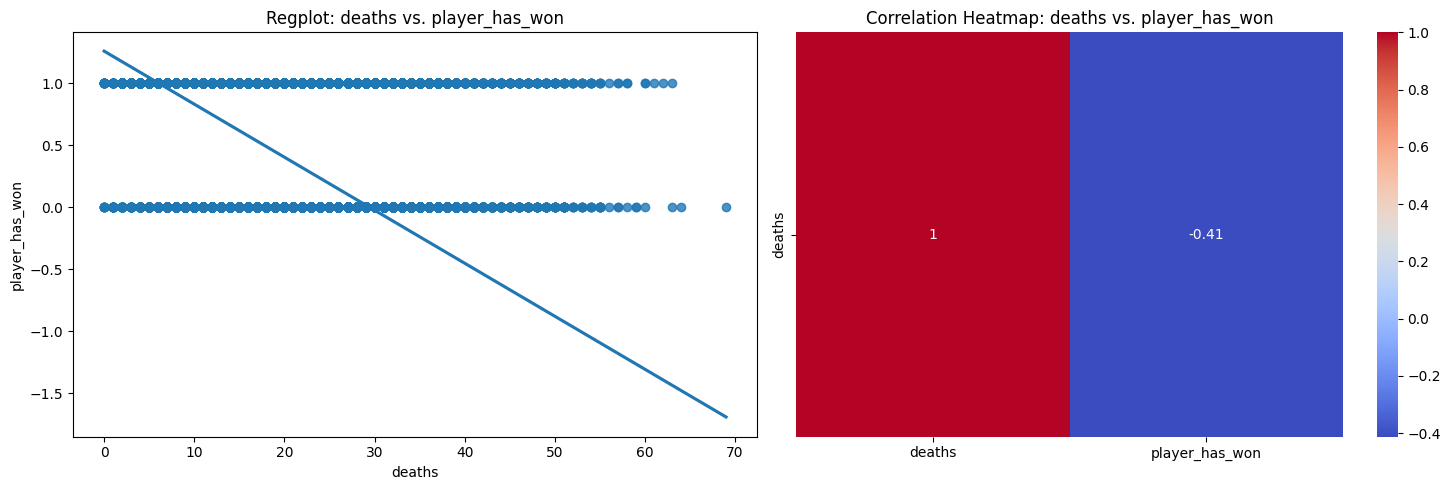

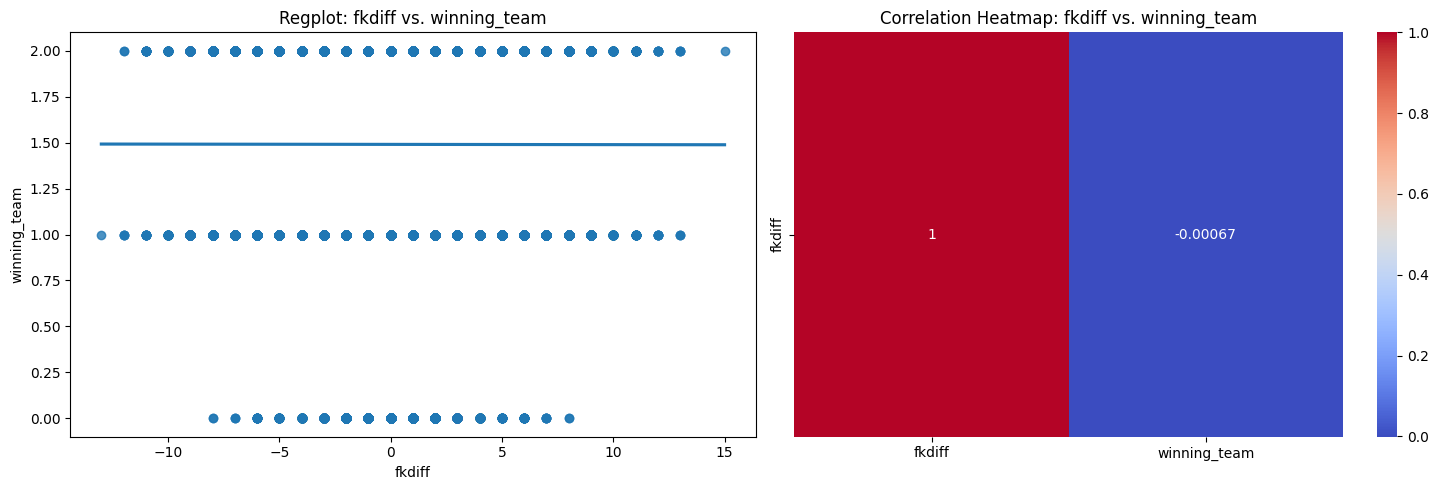

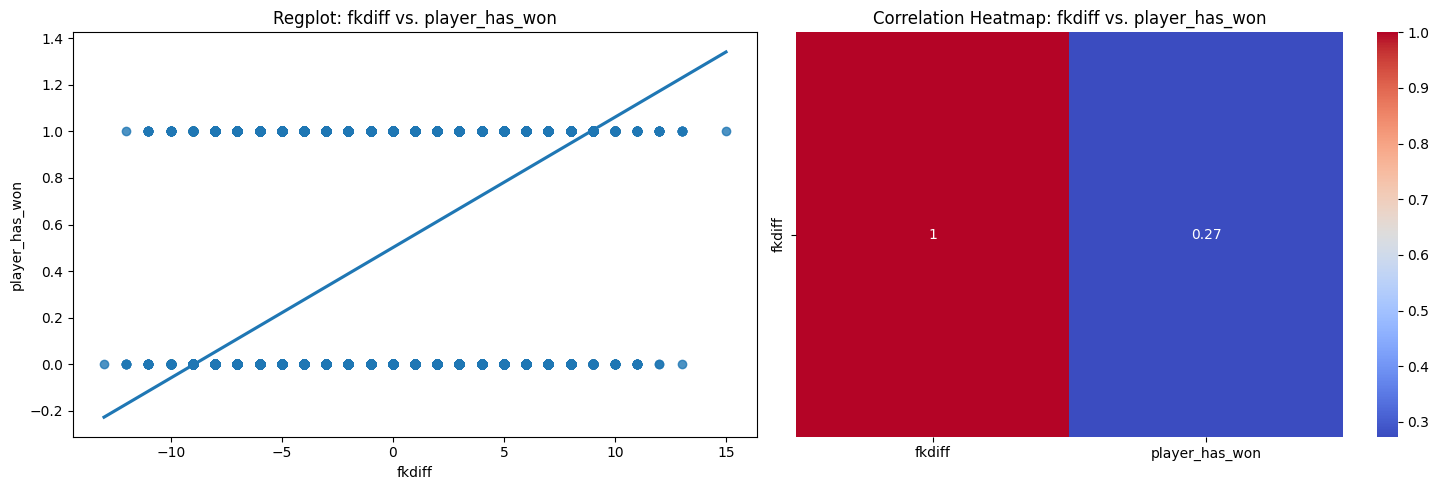

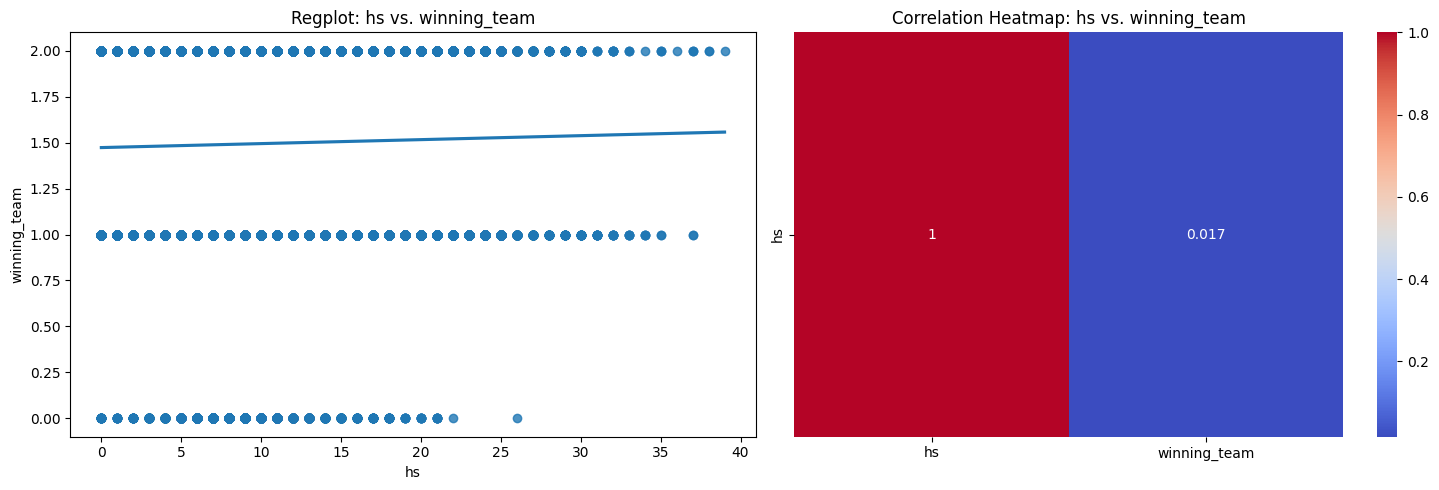

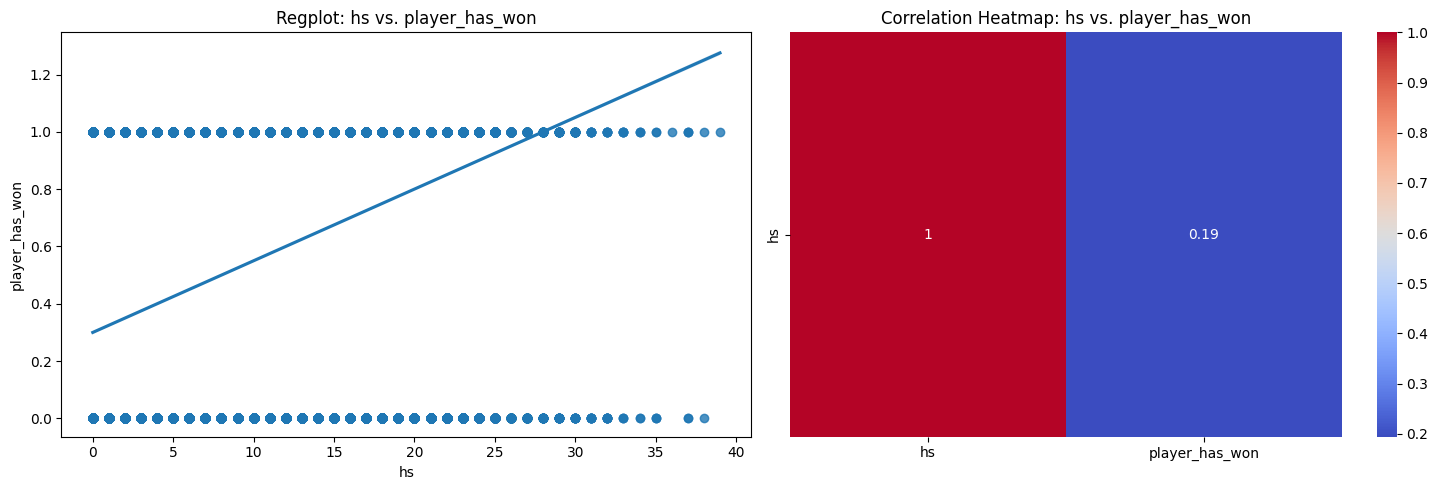

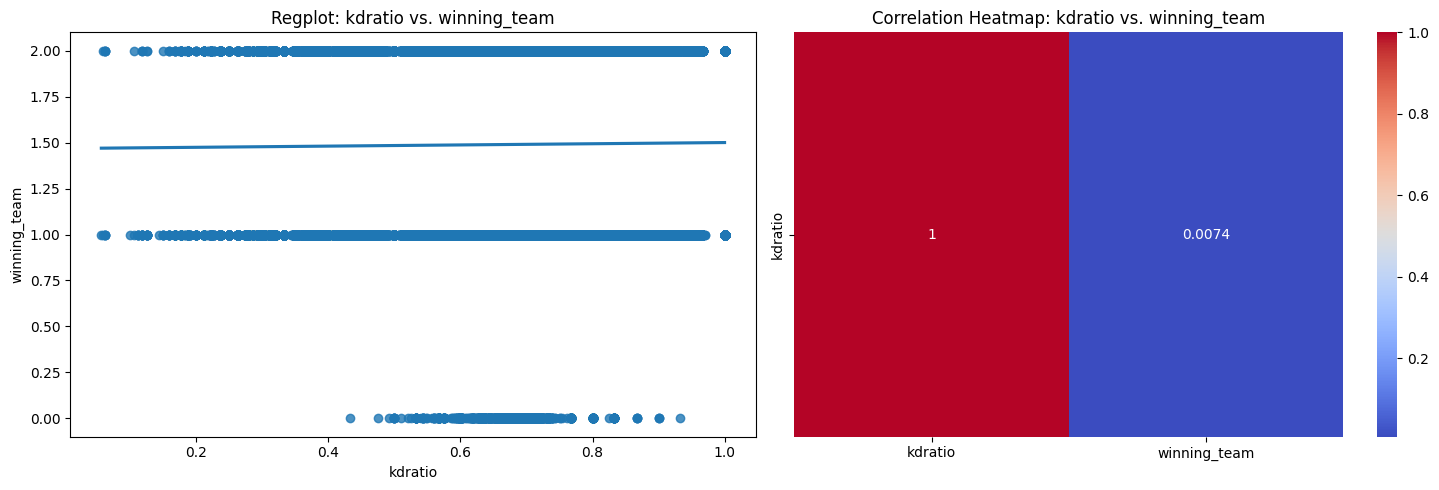

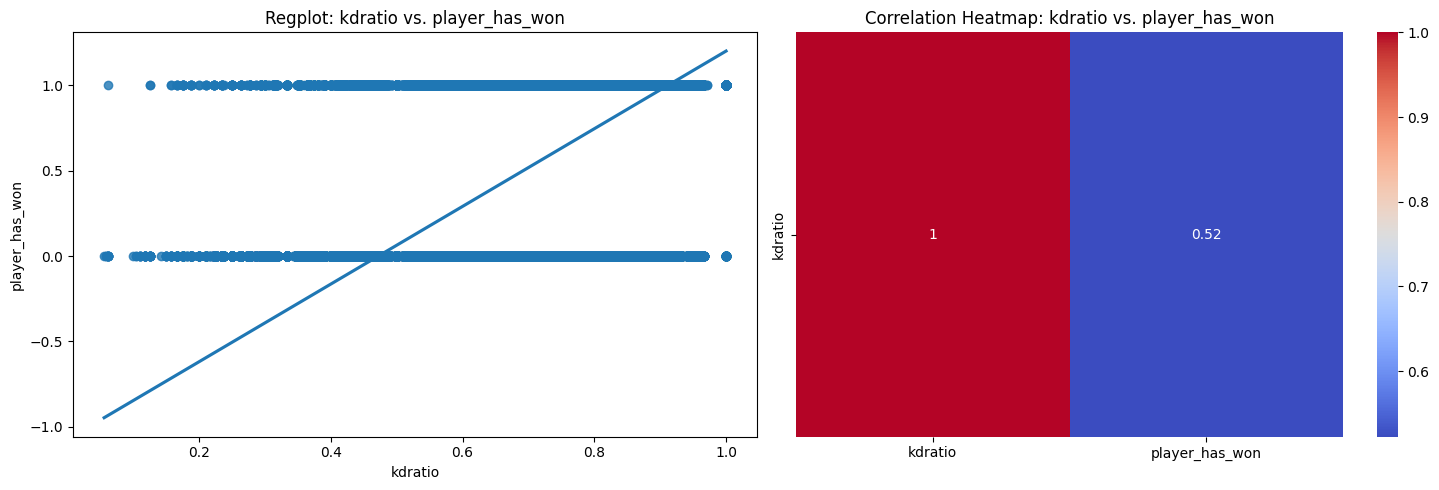

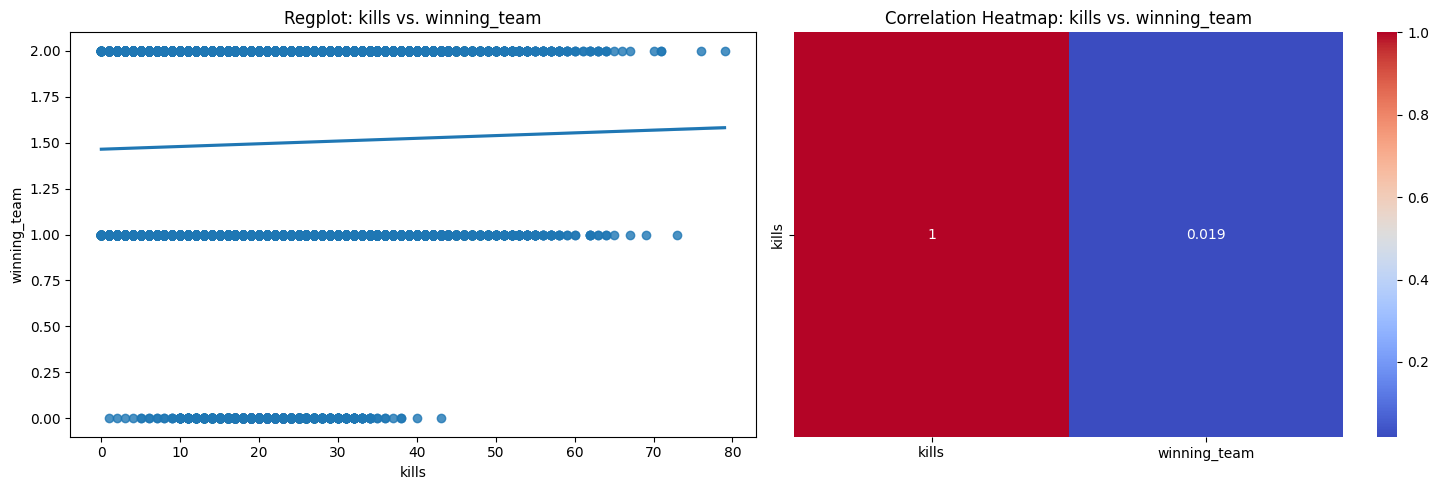

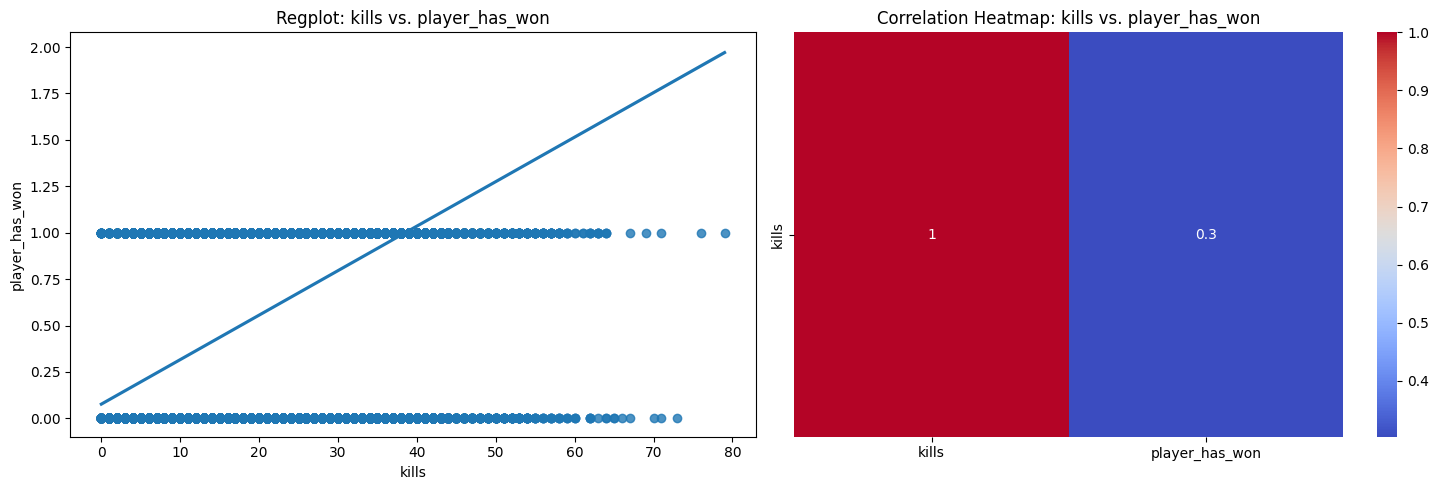

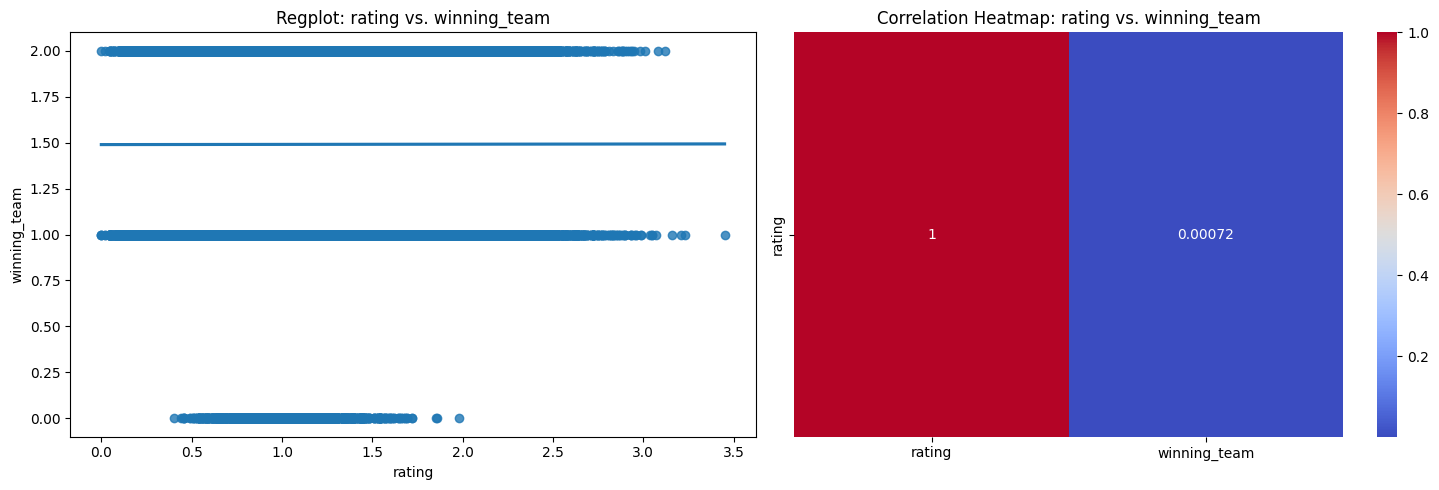

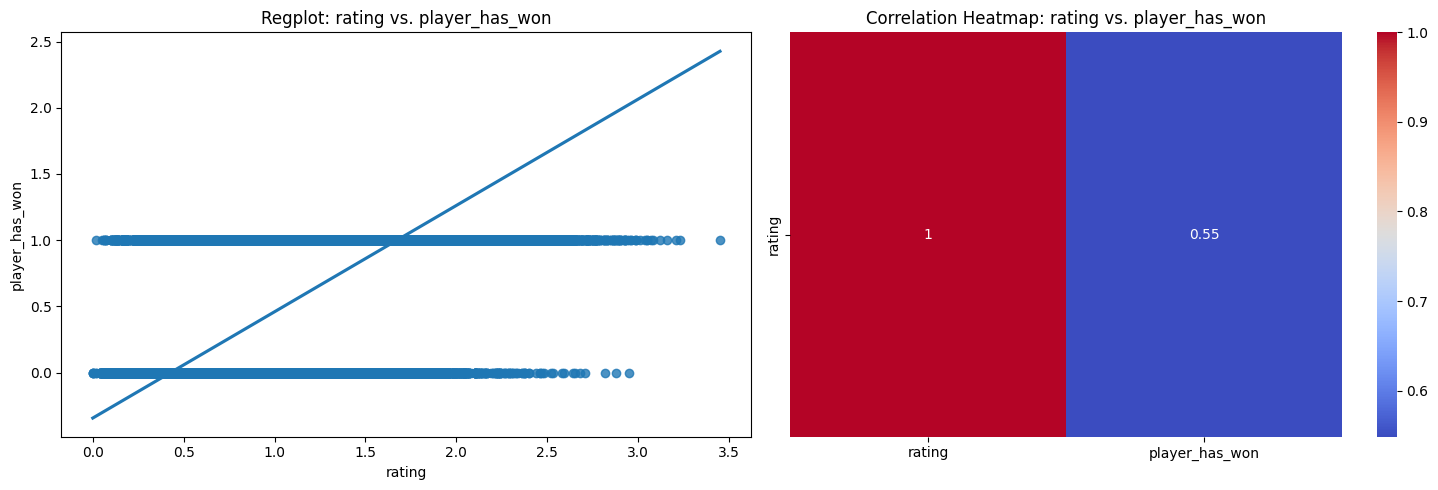

In [8]:
numeric_variables = ['adr', 'assists', 'deaths', 'fkdiff', 'hs', 'kdratio', 'kills','rating']

for column in numeric_variables:
    # Setting up the subplots for target_1
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Regression plot for target_1
    sns.regplot(x=column, y=target_1, data=total_data, ax=axes[0])
    axes[0].set_title('Regplot: {} vs. {}'.format(column, target_1))

    # Heatmap of correlation for target_1
    sns.heatmap(total_data[[column, target_1]].corr().iloc[0:1, :], annot=True, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Correlation Heatmap: {} vs. {}'.format(column, target_1))

    # Show the plot for each column with target_1
    plt.tight_layout()
    plt.show()

    # Setting up the subplots for target_2
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Regression plot for target_2
    sns.regplot(x=column, y=target_2, data=total_data, ax=axes[0])
    axes[0].set_title('Regplot: {} vs. {}'.format(column, target_2))

    # Heatmap of correlation for target_2
    sns.heatmap(total_data[[column, target_2]].corr().iloc[0:1, :], annot=True, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Correlation Heatmap: {} vs. {}'.format(column, target_2))

    # Show the plot for each column with target_2
    plt.tight_layout()
    plt.show()


After watching the numerical - numerical plots, it is possible to resume the information:

| Predictor | Corr with winning_team | Corr with player_has_won |
|-----------|-------------------------|---------------------------|
| adr       | -0.0025                 | 0.34                      |
| assists   | 0.005                   | 0.19                      |
| deaths    | 0.026                   | -0.41                     |
| fkdiff    | 0.00067                 | 0.27                      |
| hs        | 0.017                   | 0.19                      |
| kdratio   | 0.0074                  | 0.52                      |
| kills     | 0.019                   | 0.30                      |
| Rating    | 0.00072                 | 0.55                      |


It is important to state that the variable winning_team cannot be used as a target due to its low performance with other variables. Since 100% of the players have played as team 1 or team 2 during their career, this strongly affects the outcome of the variable. However, when the second path is taken and the variable player_has_won is analyized, the performance rise up to acceptable levels. This is a resume with the correlations: 

- **Rating** (0.55), **Kdratio** (0.52) and **deaths** (-0.41) have the strongest correlation.
- **adr** (0.34), **kills** (0.30) and **fkdiff** (0.27) has a good correlation.
- **assists** (0.19) and **hs** (0.19) have a poor correlation.

***Map factorization***

The only categorial variable that is has been not factorized is 'map'. The rest of the variables are already numbers. 

In [21]:
# Creating a column called 'map_n' that has the information factorized
total_data['map_n'], unique_maps = pd.factorize(total_data['map'])

***Categorical - numerical analysis***

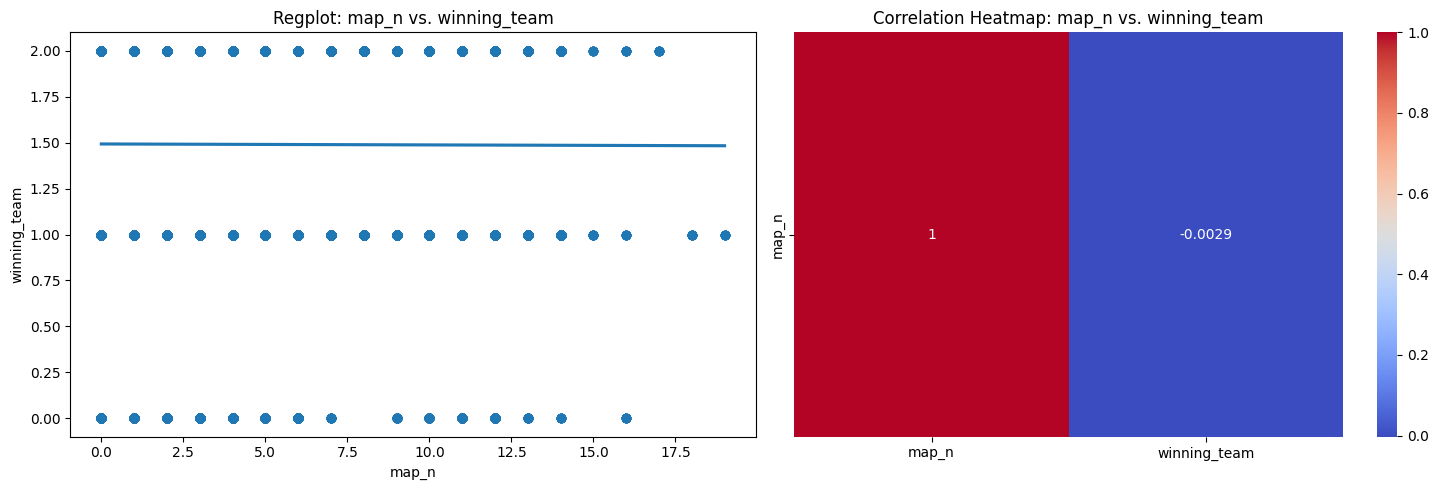

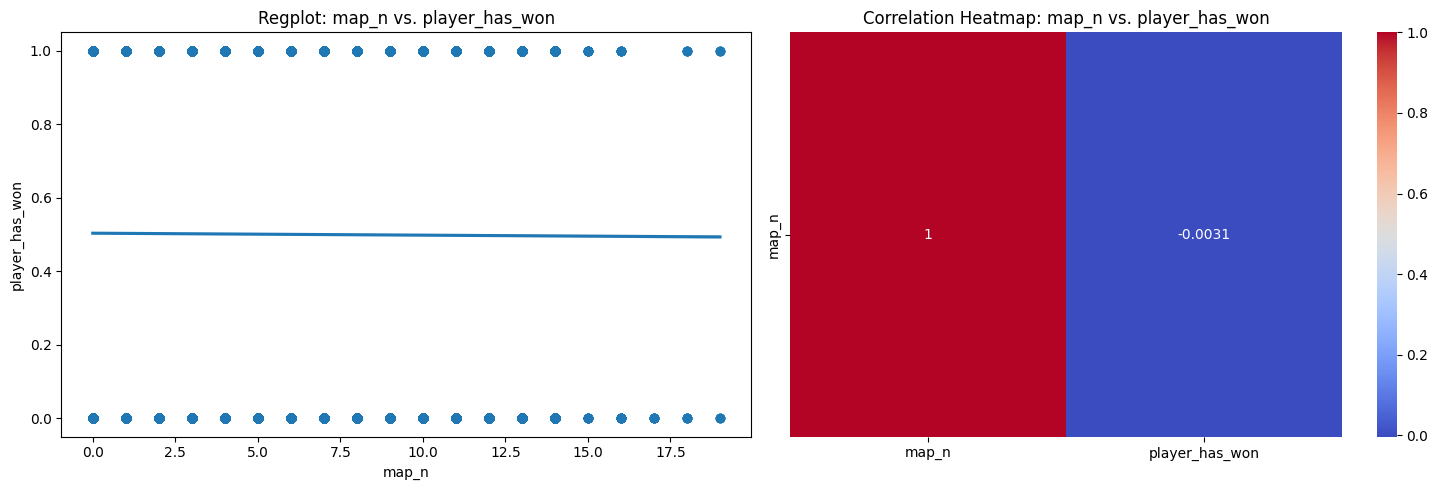

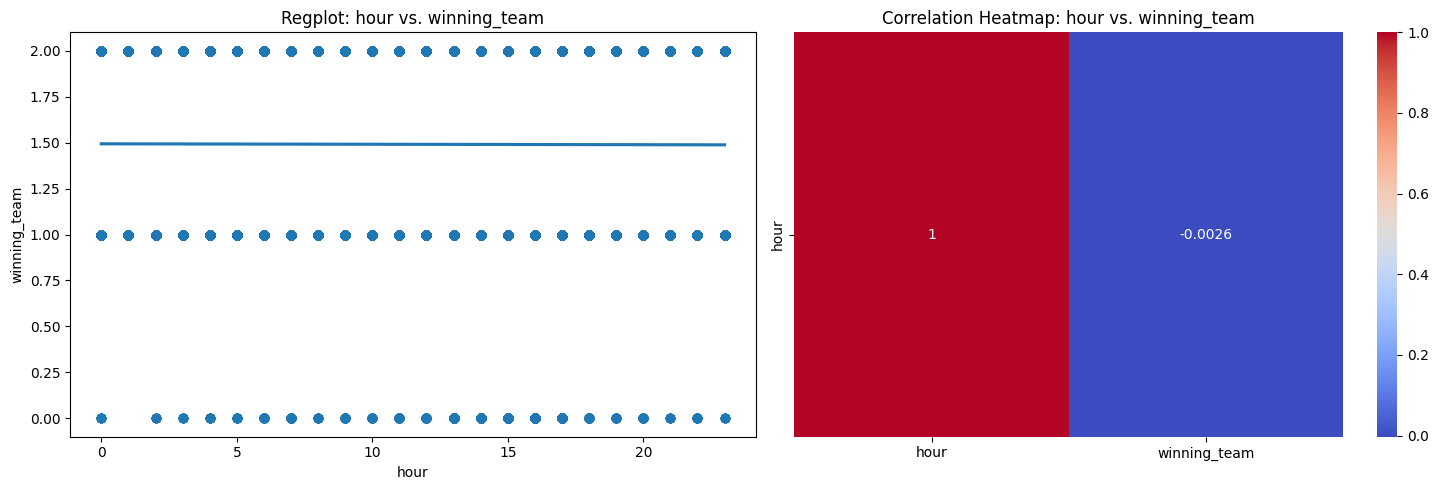

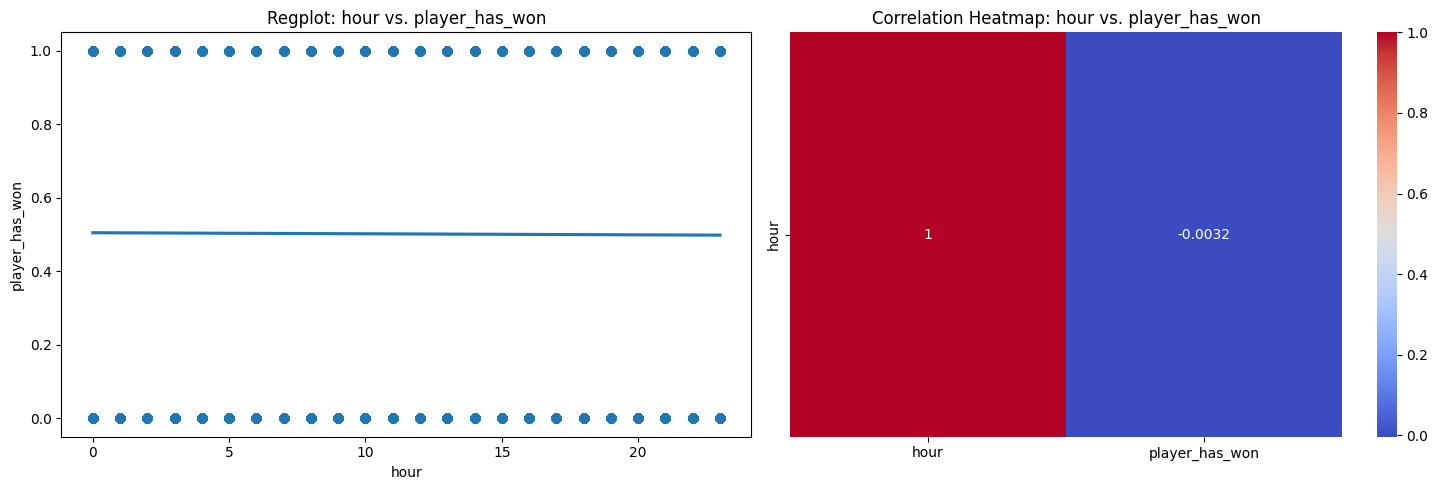

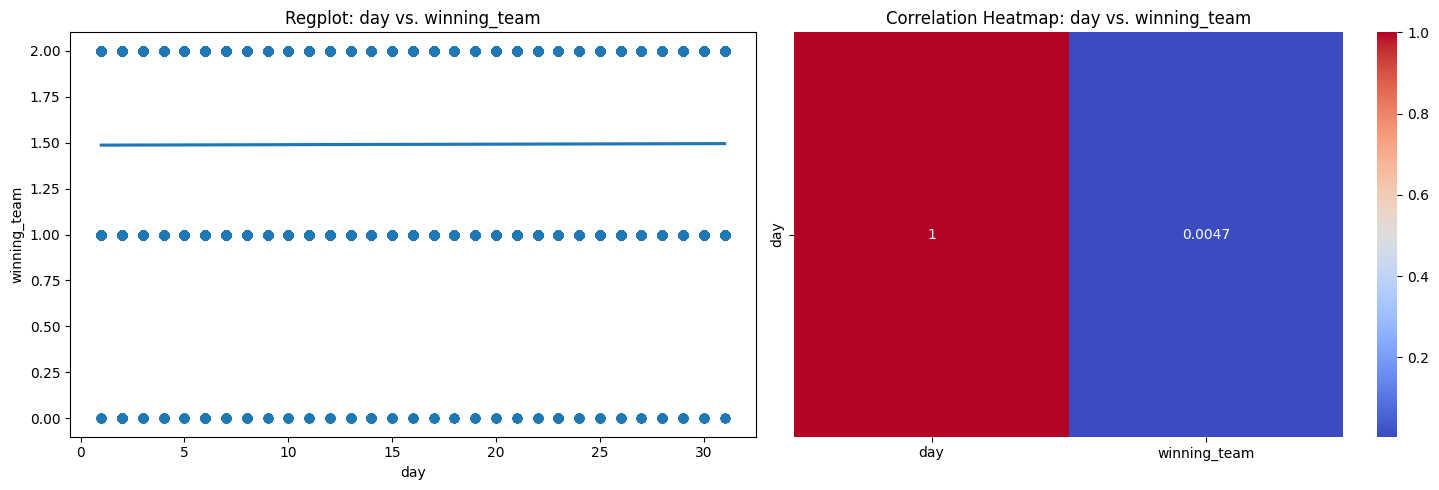

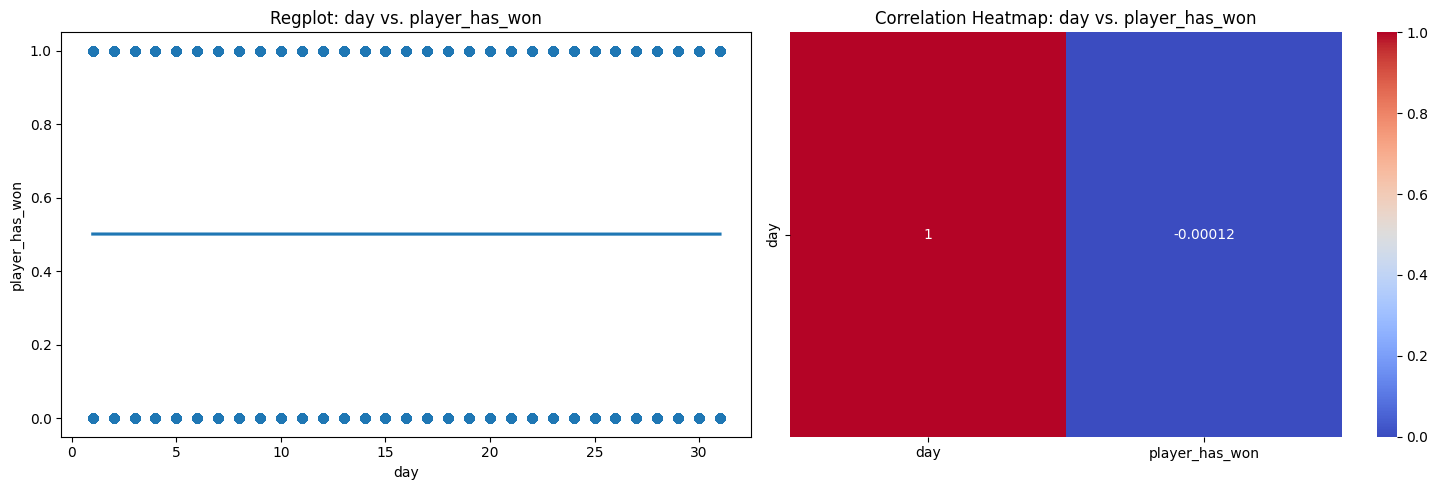

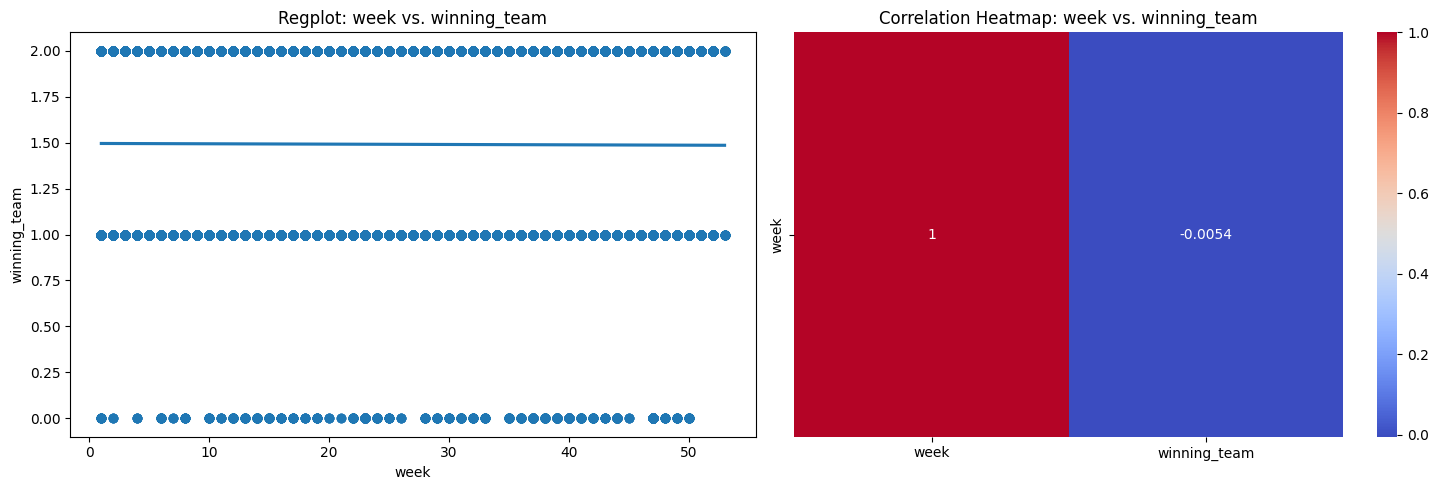

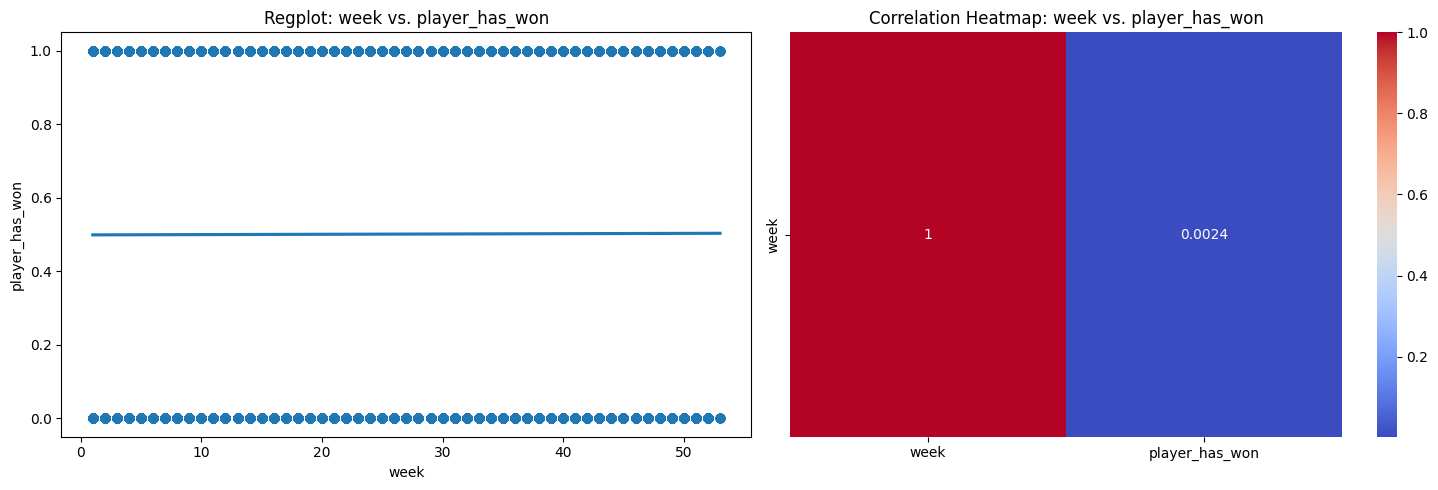

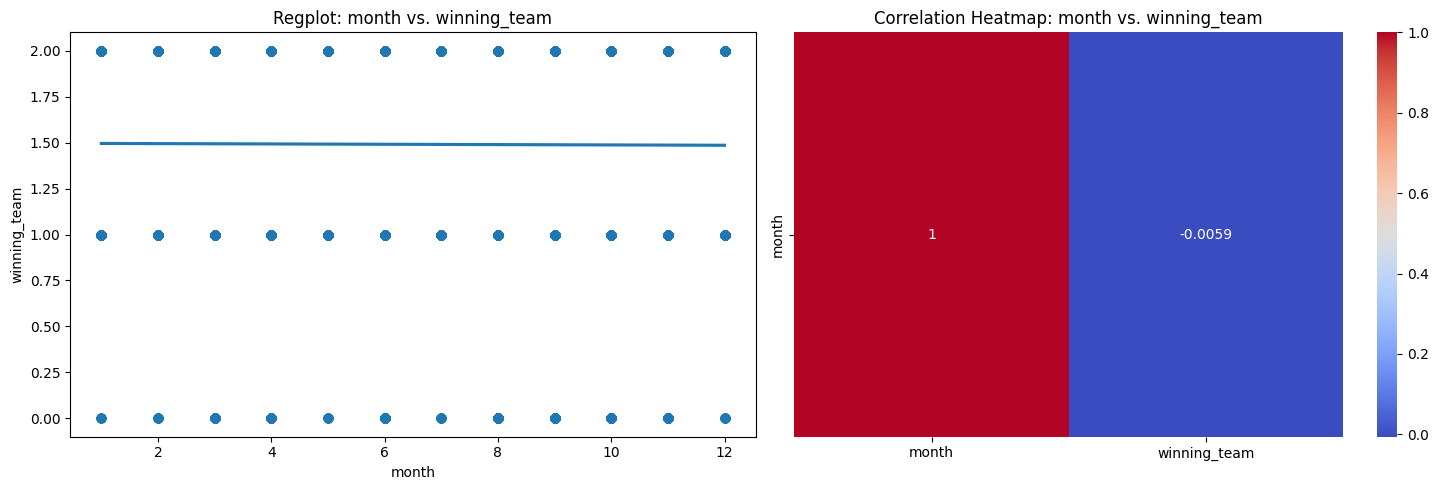

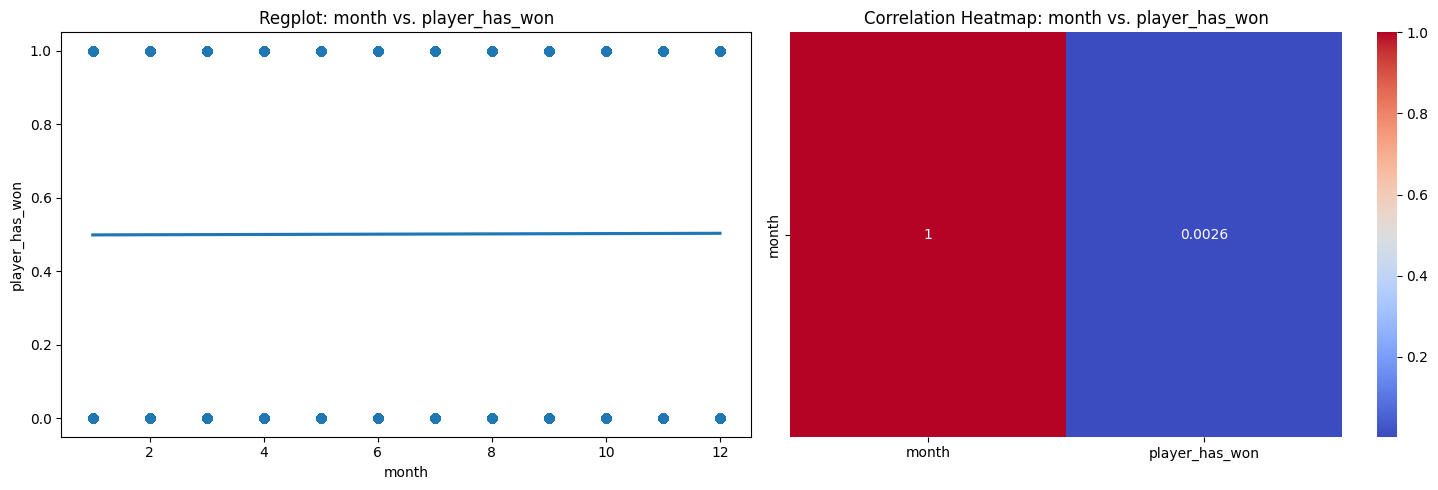

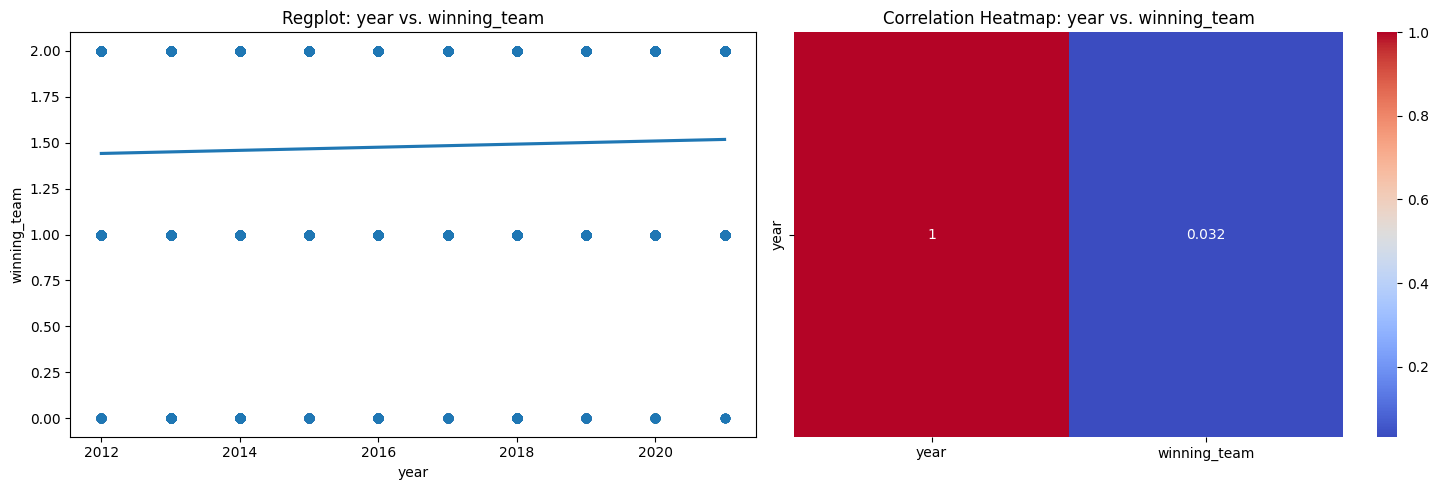

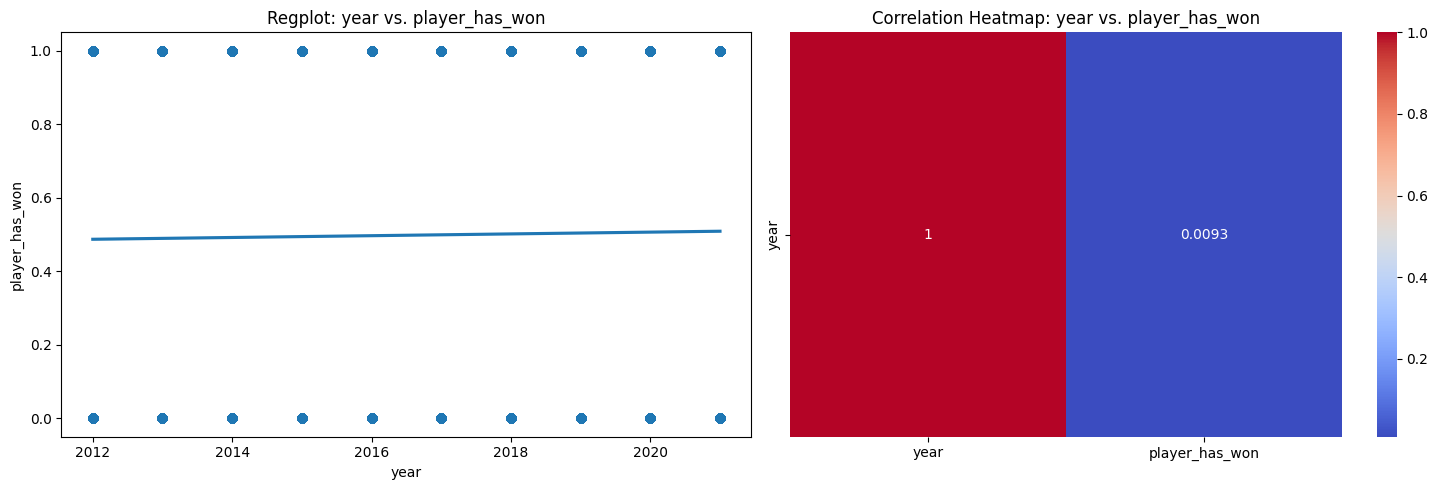

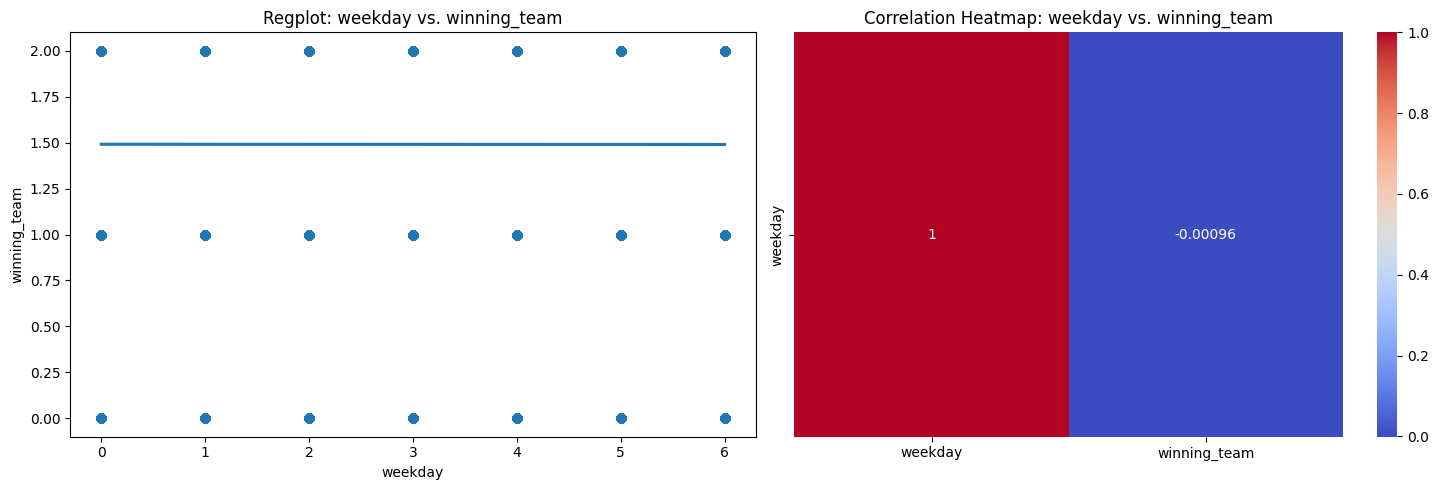

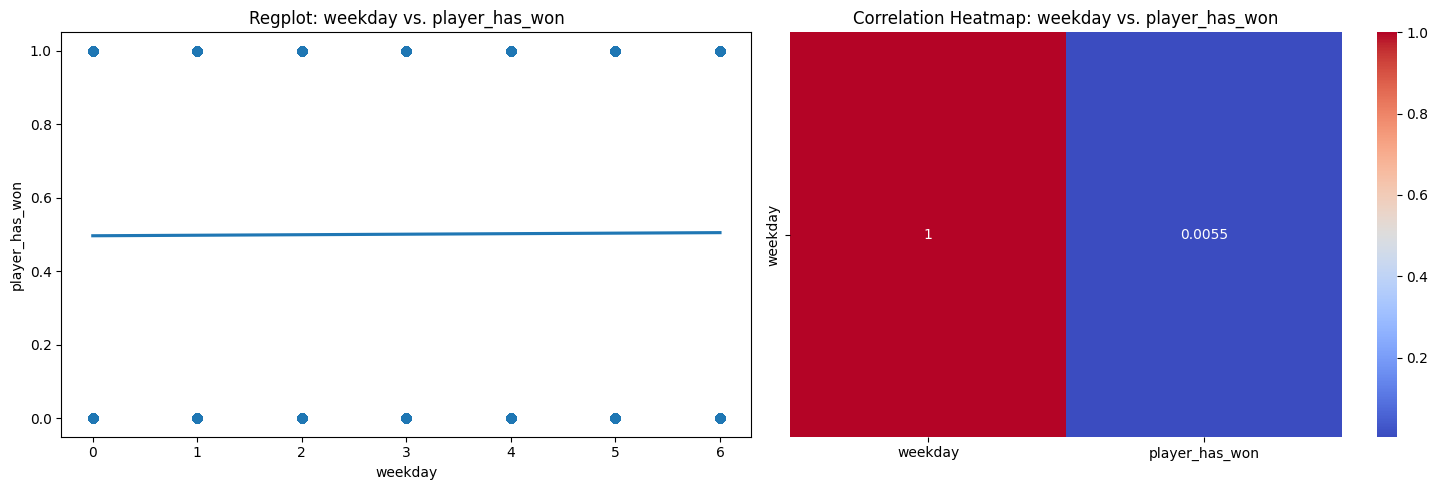

In [10]:
numeric_variables_2 = ['map_n', 'hour', 'day', 'week', 'month', 'year', 'weekday']

for column in numeric_variables_2:
    # Setting up the subplots for target_1
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Regression plot for target_1
    sns.regplot(x=column, y=target_1, data=total_data, ax=axes[0])
    axes[0].set_title('Regplot: {} vs. {}'.format(column, target_1))

    # Heatmap of correlation for target_1
    sns.heatmap(total_data[[column, target_1]].corr().iloc[0:1, :], annot=True, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Correlation Heatmap: {} vs. {}'.format(column, target_1))

    # Show the plot for each column with target_1
    plt.tight_layout()
    plt.show()

    # Setting up the subplots for target_2
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Regression plot for target_2
    sns.regplot(x=column, y=target_2, data=total_data, ax=axes[0])
    axes[0].set_title('Regplot: {} vs. {}'.format(column, target_2))

    # Heatmap of correlation for target_2
    sns.heatmap(total_data[[column, target_2]].corr().iloc[0:1, :], annot=True, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Correlation Heatmap: {} vs. {}'.format(column, target_2))

    # Show the plot for each column with target_2
    plt.tight_layout()
    plt.show()

After the plotting, it is possible to resume the info in a table: 

| Variable | Corr. with Winning Team | Corr. with Player Has Won |
|----------|-------------------------|---------------------------|
| map      | -0.0029                 | -0.0031                   |
| hour     | -0.0026                 | -0.0032                   |
| day      | 0.0047                  | -0.00012                  |
| week     | -0.0054                 | 0.0024                    |
| month    | -0.0059                 | 0.0026                    |
| year     | 0.032                   | 0.0093                    |
| weekday  | -0.00096                | 0.0055                    |

In both cases, the correlations with the target variables are extremely low, meaning that they have almost no use in the analysis. In the overall, the first target (winning_team) performed better than the second target (player_has_won). However, due to their poor performance, they will be deleted from the EDA.

***General heatmap***

For the heatmap, the following creiteria has been used to filter:

- The group ID and name variables have been removed because it is not possible to use them for the machine learning model.
- Time group variables were deleted due to their poor performance with both target variables.
- From the group of created variables, only 'player_has_won' target provided possitive outcome. Thus, that will be the only to remain.

This means that only the statistics group and the target 2 remains.

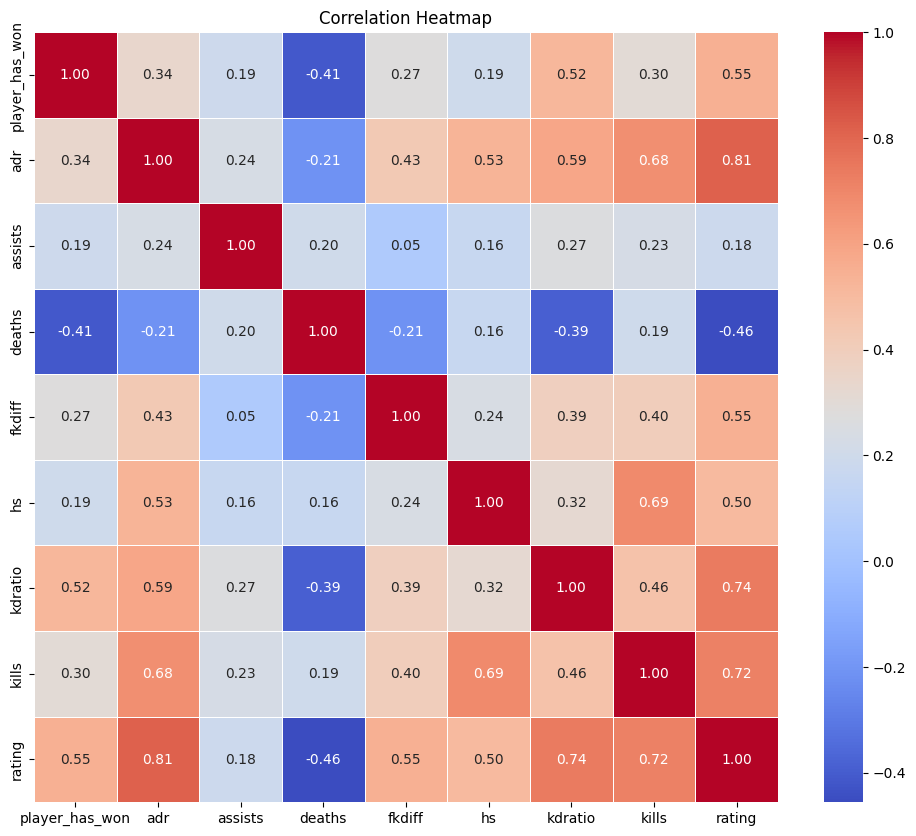

In [16]:
heatmap_data = total_data[['player_has_won', 
                 'adr', 
                 'assists', 
                 'deaths', 
                 'fkdiff', 
                 'hs', 
                 'kdratio', 
                 'kills',
                 'rating',]]

correlation_matrix = heatmap_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

This graph shows that there are some strong correlations between variables in the dataset. For example, adr (average damage per round) and kills are also strongly correlated variables. It is possible to say that from the original dataset of 26 columns, the EDA found that only seven predictors are important to predict the possible outcome of a player in a CS-GO match.

There is a special mention of the variable **'rating'**. This is made up of other predictors, so its correlation with the rest is the highest in the dataset. However, we do not count with the information to know exactly how this variable is made. This could negatively affect the research and the ML model.

### 4.4 Outlier analysis

***Filtering only the wanted variables***

In [35]:
total_data.columns

Index(['adr', 'assists', 'deaths', 'fkdiff', 'hs', 'kdratio', 'kills',
       'rating', 'match_id', 'player_id', 'team_1_id', 'team_1_score',
       'team_2_id', 'team_2_score', 'team_name', 'data_unix', 'map', 'hour',
       'day', 'week', 'month', 'year', 'weekday', 'player_team_id',
       'winning_team', 'winning_team_id', 'player_has_won', 'map_n'],
      dtype='object')

In [51]:
# Combine day, month, and year columns to create a new 'date' column
total_data['match_date'] = pd.to_datetime(total_data[['year', 'month', 'day']], errors='coerce')

# Create a new dataset
player_stats = total_data[['player_id','player_team_id', 'match_date', 'adr', 'assists', 'deaths', 'fkdiff', 'hs', 'kdratio', 'kills','player_has_won']]

# Group by one player ID - number 7
filtered_df = player_stats[player_stats['player_id'] == 7]


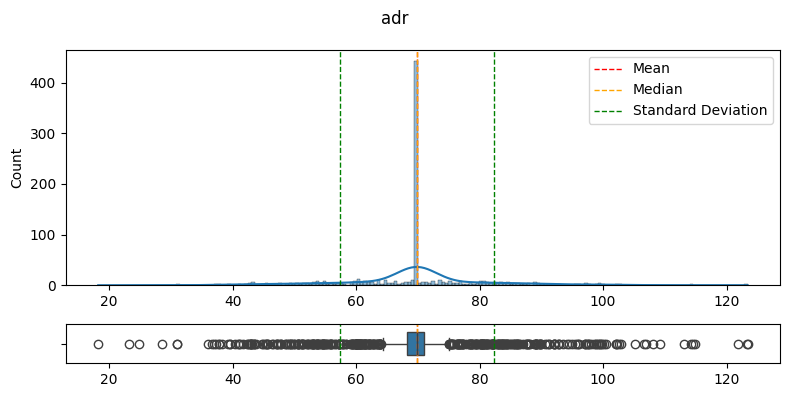

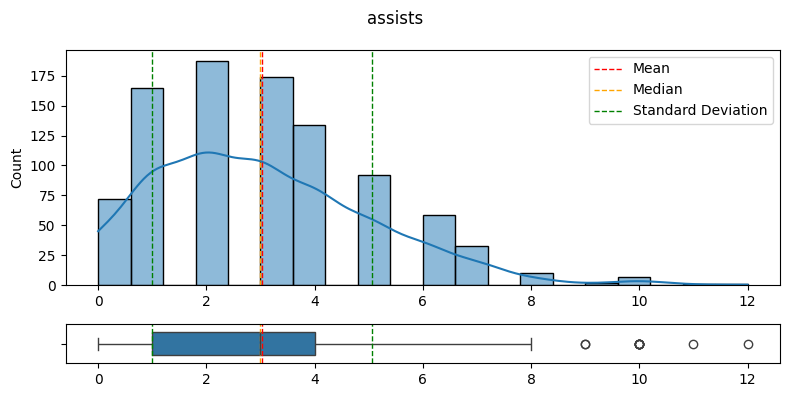

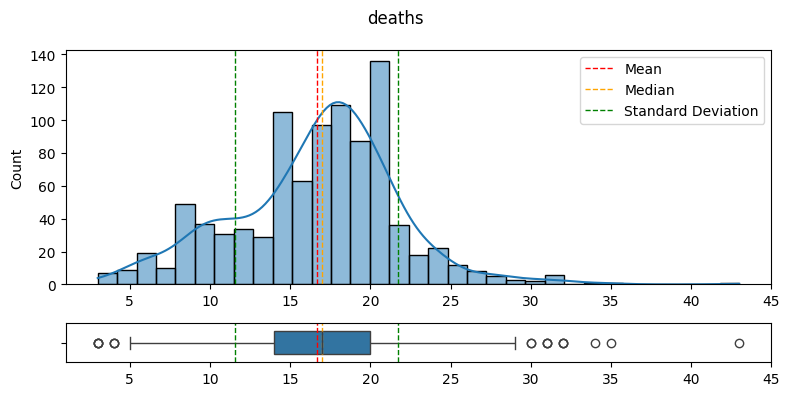

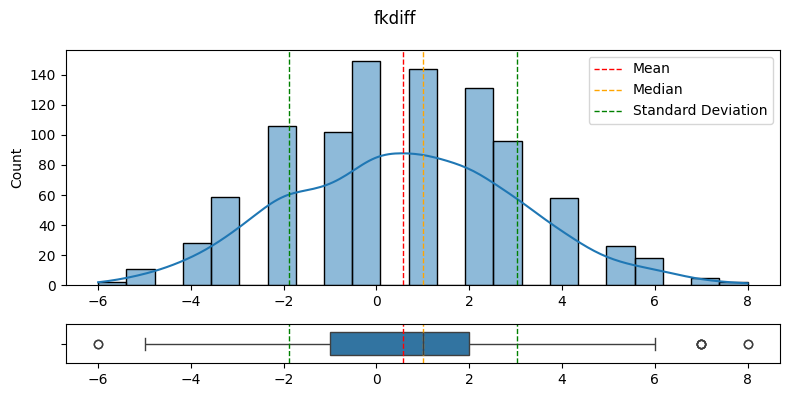

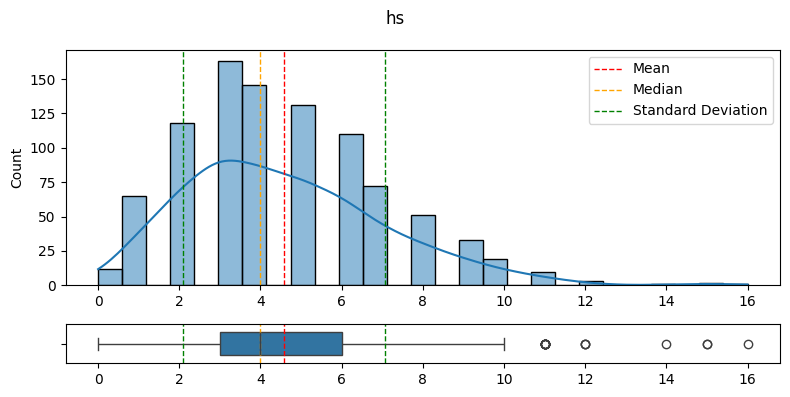

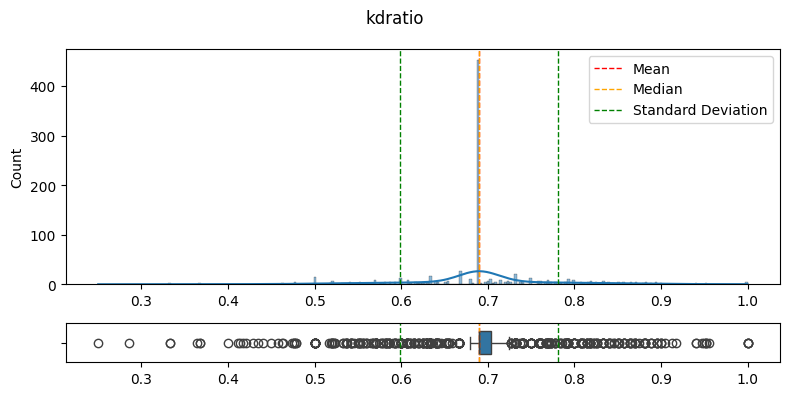

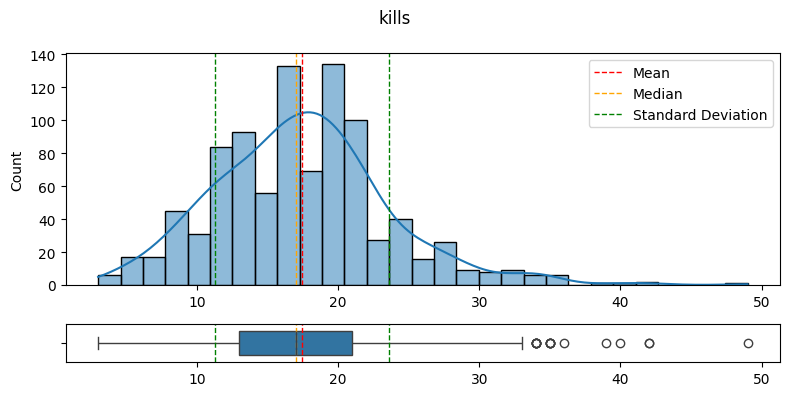

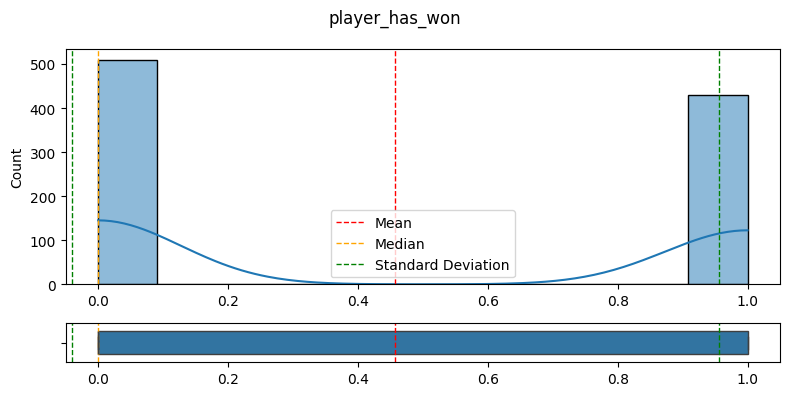

In [52]:
def plot_numerical_data(dataframe):
    ploting_columns = dataframe[['adr', 'assists', 'deaths', 'fkdiff', 'hs', 'kdratio', 'kills','player_has_won']].columns

    for column in ploting_columns:
        fig, axis = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={'height_ratios': [6, 1]}) 
        # Calculate mean, median, and standard deviation
        mean_val = np.mean(dataframe[column])
        median_val = np.median(dataframe[column])
        std_dev = np.std(dataframe[column])

        # Create a multiple subplots with histograms and box plots
        sns.histplot(ax=axis[0], data=dataframe, kde=True, x=column).set(xlabel=None)
        axis[0].axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label='Mean')
        axis[0].axvline(median_val, color='orange', linestyle='dashed', linewidth=1, label='Median')
        axis[0].axvline(mean_val + std_dev, color='green', linestyle='dashed', linewidth=1, label='Standard Deviation')
        axis[0].axvline(mean_val - std_dev, color='green', linestyle='dashed', linewidth=1)  

        sns.boxplot(ax=axis[1], data=dataframe, x=column, width=0.6).set(xlabel=None)
        axis[1].axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label='Mean')
        axis[1].axvline(median_val, color='orange', linestyle='dashed', linewidth=1, label='Median')
        axis[1].axvline(mean_val + std_dev, color='green', linestyle='dashed', linewidth=1)
        axis[1].axvline(mean_val - std_dev, color='green', linestyle='dashed', linewidth=1)  

        axis[0].legend()  
        fig.suptitle(column)
        plt.tight_layout()
        plt.show()

# Assuming total_data is your DataFrame
plot_numerical_data(filtered_df)

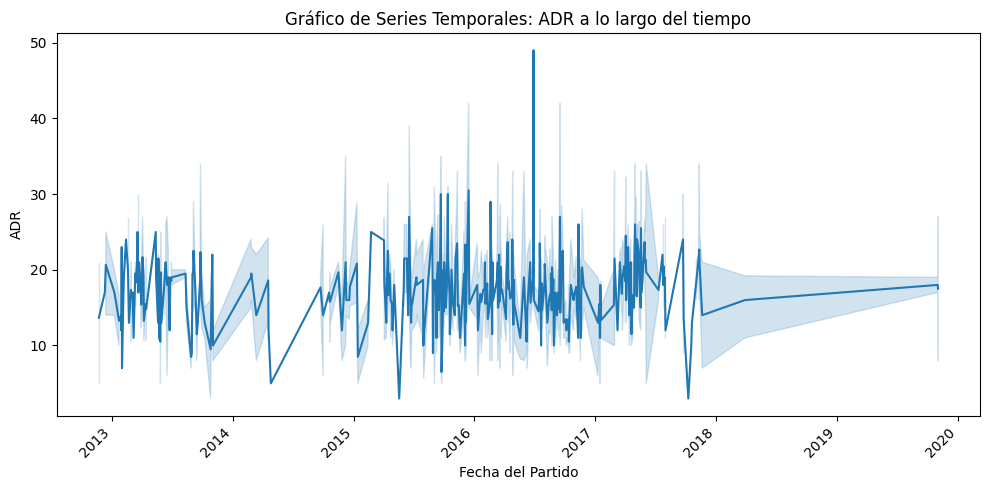

In [56]:

# Configura el tamaño del gráfico
plt.figure(figsize=(10, 5))

# Crea el gráfico de series temporales
sns.lineplot(x='match_date', y='kills', data=filtered_df)

# Configura el formato de las fechas en el eje X
plt.xticks(rotation=45, ha="right")  # Ajusta la rotación de las fechas para mayor legibilidad

# Añade etiquetas y título
plt.xlabel('Fecha del Partido')
plt.ylabel('ADR')
plt.title('Gráfico de Series Temporales: ADR a lo largo del tiempo')

# Muestra el gráfico
plt.tight_layout()
plt.show()

DEJO UN PAR DE REFLEXIONES.

Hasta aqui conseguimos un dataset que nos provee informacion dentro de todo buena sobre **si un jugador tiene o no chances de ganar una partida.** No obstante, esta informacion nunca va a ser dada de antemano a un partido, por lo que simplemente el modelo confirmaria algo que ya tendremos. 

El objetivo es que el modelo final logre ancipar un equipo ganador teniendo como input los miembros de cada equipo.

Que pasos a seguir podriamos tener:

(IDEA DE FRAN)

1. Ahora que sabemos que las estadisticas son las unicas variables que afectan a la victoria de un jugador, es posible que **analicemos la trayectoria de un jugador y le demos un numero de acuerdo a su performance historica**. Cada performance historica puede ser un numero unico (asumiendo que ningun jugador va a tener exactamente las mismas características).

2. El modelo principal podría tener columnas que son las performance de los miembros de los equipos (ordenadas). Y la target podría dar 0 o 1 dependiendo de los jugadores de cada equipo. 

3. Podriamos usar un random forest para que calcule, por ejemplo, 100 veces una partida y de la victora por un % de veces.



### 4.5. FEATURE ENGINEERING

***CREATING PCA***

In [ ]:
from sklearn.decomposition import PCA

# Cargar el conjunto de datos Iris
iris = load_iris()
X = iris.data
y = iris.target

# Crear un objeto PCA y ajustarlo a los datos
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

***TFIDF VECTORIZER***

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokens_list = total_data["Message"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["Category"]
X[:5]